In [1]:
import sys
sys.path.append("./")
sys.path.append("../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import polyfit, poly1d
from sklearn.metrics import r2_score
from scipy.optimize import minimize


def calculate_pass_loss_decile(score_series, y_series):
    """
    模型分取值变化时通过率与坏账率关系
    :param score_series: 模型分
    :param y_series: Y标签
    :return:  
    """
    decile_df = pd.crosstab(score_series, y_series).rename(columns={0: 'N_nonEvent', 1: 'N_Event'})
    decile_df.loc[:, 'N_sample'] = score_series.value_counts()

    decile_df.loc[:, 'EventRate'] = decile_df.N_Event * 1.0 / decile_df.N_sample
    decile_df.loc[:, 'BadPct'] = decile_df.N_Event * 1.0 / sum(decile_df.N_Event)
    decile_df.loc[:, 'GoodPct'] = decile_df.N_nonEvent * 1.0 / sum(decile_df.N_nonEvent)
    decile_df.loc[:, 'CumBadPct'] = decile_df.BadPct.cumsum()
    decile_df.loc[:, 'CumGoodPct'] = decile_df.GoodPct.cumsum()

    decile_df = decile_df.sort_index(ascending=False)
    decile_df.loc[:, 'ApprovalRate'] = decile_df.N_sample.cumsum() / decile_df.N_sample.sum()
    decile_df.loc[:, 'ApprovedEventRate'] = decile_df.N_Event.cumsum() / decile_df.N_sample.cumsum()
    decile_df = decile_df.sort_index(ascending=True)
    return decile_df


def poly_regression(x_series, y_series, degree, plot=True):
    """
    多项式回归拟合
    :param x_series: x数据
    :param y_series: y数据
    :param degree: 指定多项式次数
    :param plot: 是否作图
    :return:
    """
    coeff = polyfit(x_series, y_series, degree)
    f = poly1d(coeff)
    R2 = r2_score(y_series.values, f(x_series))

    print(f'coef:{coeff},R2: {R2}')

    if plot:
        # 用来正常显示中文标签
        plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
        plt.rcParams['axes.unicode_minus'] = False

        plt.figure(figsize=(10, 5))
        plt.plot(x_series, y_series, 'rx')
        plt.plot(x_series, f(x_series))
        plt.xlabel('通过率', {'size': 15})
        plt.ylabel('坏账率', {'size': 15})
        plt.show()
    return coeff

def find_best_approval_rate(x_to_loss_func, score_df,average_limit,interest_rate,Fixed_cost,rules_approval_rate):
    """
    定义最优化函数
    坏账率L(x)与通过率x的关系函数
    :param x_to_loss_func: 坏账率与通过率的函数关系
    :param score_df: 模型分与通过率的对应关系，index为模型分，"ApprovalRate"列为对应的通过率
    :param average_limit: 本利率下的件均额度
    :param interest_rate: 利率
    :param Fixed_cost: 件均固定成本
    :param rules_approval_rate: 模型外规则通过率
    :return:
    """

    # 定义目标函数，求解最大值即为负的最小值
    def fun(x_array):
        # 其中x_list[0]为通过率x，x_array[1]为对应的坏账率L(x)
        return -average_limit * (interest_rate * (1 - x_array[1]) - x_array[1]
                         - Fixed_cost / (x_array[0] * rules_approval_rate) / average_limit)

    # eq表示 函数结果等于0 ； ineq 表示 表达式大于等于0， 下面式子1e-6项确保相应变量不等于0或1
    cons = ({'type': 'eq', 'fun': lambda x_array: x_to_loss_func(x_array[0]) - x_array[1]},
            {'type': 'ineq', 'fun': lambda x_array: x_array[0] - 1e-6},
            {'type': 'ineq', 'fun': lambda x_array: x_array[1] - 1e-6},
            {'type': 'ineq', 'fun': lambda x_array: 1 - x_array[0] - 1e-6},
            {'type': 'ineq', 'fun': lambda x_array: 1 - x_array[0] - 1e-6}
            )

    # 设置初始值
    x_base = np.array((0.10, 0.10))
    # 采用SLSQP进行最优化求解
    res = minimize(fun, x_base, method='SLSQP', constraints=cons)
    print('利润最优：', "{:.2f}".format(-res.fun))
    print('最优解对应通过率：', "{:.2%}".format(res.x[0]), '坏账率：', "{:.2%}".format(res.x[1]))
    print("模型分阈值：", score_df[score_df['ApprovalRate'] >= res.x[0]].index.max())
    print('迭代终止是否成功：', res.success)
    print('迭代终止原因：', res.message)

In [5]:
german_score = pd.read_csv('data/german_score.csv')
german_score

,score,creditability
0,557.0,0
1,337.0,1
2,504.0,0
3,404.0,0
4,495.0,1
...,...,...
995,443.0,0
996,407.0,0
997,455.0,0
998,349.0,1


In [3]:
decile_df = calculate_pass_loss_decile(german_score['score'],
                                       german_score['creditability'])

In [4]:
decile_df 

creditability,N_nonEvent,N_Event,N_sample,EventRate,BadPct,GoodPct,CumBadPct,CumGoodPct,ApprovalRate,ApprovedEventRate
score,,,,,,,,,,
266.0,0,1,1,1.0,0.003333,0.000000,0.003333,0.000000,1.000,0.300000
289.0,1,0,1,0.0,0.000000,0.001429,0.003333,0.001429,0.999,0.299299
291.0,1,1,2,0.5,0.003333,0.001429,0.006667,0.002857,0.998,0.299599
293.0,0,1,1,1.0,0.003333,0.000000,0.010000,0.002857,0.996,0.299197
294.0,0,1,1,1.0,0.003333,0.000000,0.013333,0.002857,0.995,0.298492
...,...,...,...,...,...,...,...,...,...,...
585.0,1,0,1,0.0,0.000000,0.001429,1.000000,0.994286,0.005,0.000000
587.0,1,0,1,0.0,0.000000,0.001429,1.000000,0.995714,0.004,0.000000
588.0,1,0,1,0.0,0.000000,0.001429,1.000000,0.997143,0.003,0.000000


coef:[-0.05450469  0.13799401  0.04632357],R2: 0.9049285306847179


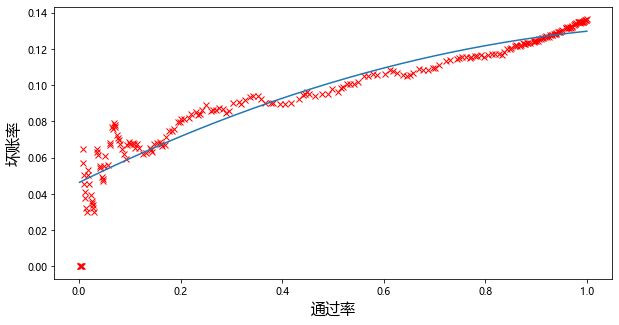

         2
-0.0545 x + 0.138 x + 0.04632


In [15]:
# 数据准备
x = decile_df['ApprovalRate']
# 逾期率折算为坏账率，这里的2.5需要根据真实的逾期率和坏账率比率来设定
y = decile_df['ApprovedEventRate'] / 2.2
poly_coef = poly_regression(x, y, 2, plot=True)
# 坏账率L(x)与通过率x的关系
l_x = poly1d(poly_coef)
print(l_x)

In [13]:
find_best_approval_rate(l_x, decile_df,average_limit=10000,interest_rate=0.24,Fixed_cost=30,rules_approval_rate=0.7)

利润最优： 1404.69
最优解对应通过率： 18.23% 坏账率： 6.13%
模型分阈值： 484.0
迭代终止是否成功： True
迭代终止原因： Optimization terminated successfully
